In [1]:
import keras
from keras.layers import Input, Dense, GRU, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features
from models.models import gru_model
from evaluation import makeRoc, learningCurveLoss

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config  outputDir ")
options = Option(
    inputModel = 'KERAS_gru_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]
#features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j1_pt']
#labels = ['j_g','j_q','j_w','j_z','j_t']

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j_q,j1_ptrel,j1_phirot,j1_etarot,j_g,j1_pdgid,j1_deltaR,j_z,j1_erel,j_w,j_t,j_index
0,0,0.386118,0.000000,0.000000,1,130.0,0.011056,0,0.382772,0,0,101333
1,0,0.107734,0.007236,-0.009859,1,211.0,0.023104,0,0.105703,0,0,101333
2,0,0.094731,-0.002759,0.004508,1,321.0,0.006306,0,0.094339,0,0,101333
3,0,0.042086,-0.014909,0.028567,1,211.0,0.022473,0,0.042913,0,0,101333
4,0,0.039412,-0.003745,-0.018020,1,-211.0,0.025492,0,0.038547,0,0,101333
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0,0.000350,-0.315306,-0.300495,0,111.0,0.380018,1,0.000344,0,0,300123134
5131609,0,0.000258,-0.349366,0.258936,0,111.0,0.294476,1,0.000256,0,0,300123134
5131610,0,0.000219,-0.270430,0.269149,0,111.0,0.255231,1,0.000215,0,0,300123134
5131611,0,0.000116,-0.341398,-0.213081,0,111.0,0.319973,1,0.000115,0,0,300123134


In [4]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

C:\Users\jjren\GRU\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [5]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = GRU(20,kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu', recurrent_activation='sigmoid', name='gru_selu',)(Inputs)
x = Dense(20,kernel_regularizer=l1(l1Reg),activation='relu', kernel_initializer='lecun_uniform', name='dense_relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1680      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [6]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(X_train_val, y_train_val, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 17s 9ms/step - loss: 1.1994 - accuracy: 0.5508 - val_loss: 1.0183 - val_accuracy: 0.6520
Epoch 2/100
1852/1852 [==============================] - 15s 8ms/step - loss: 1.0194 - accuracy: 0.6455 - val_loss: 0.9634 - val_accuracy: 0.6674
Epoch 3/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9795 - accuracy: 0.6637 - val_loss: 0.9316 - val_accuracy: 0.6786
Epoch 4/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9525 - accuracy: 0.6771 - val_loss: 0.9140 - val_accuracy: 0.6918
Epoch 5/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9336 - accuracy: 0.6846 - val_loss: 0.8974 - val_accuracy: 0.6983
Epoch 6/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9239 - accuracy: 0.6911 - val_loss: 0.9011 - val_accuracy: 0.6961
Epoch 7/100
1852/1852 [==============================] - 14s 8ms/step - loss: 0.9119 - accuracy: 0.6929 - val_loss: 0.8922 -

Epoch 57/100
1852/1852 [==============================] - 14s 8ms/step - loss: 0.8514 - accuracy: 0.7138 - val_loss: 0.8195 - val_accuracy: 0.7243
Epoch 58/100
1852/1852 [==============================] - 14s 8ms/step - loss: 0.8482 - accuracy: 0.7155 - val_loss: 0.8482 - val_accuracy: 0.7104
Epoch 59/100
1852/1852 [==============================] - 14s 8ms/step - loss: 0.8503 - accuracy: 0.7145 - val_loss: 0.8243 - val_accuracy: 0.7201
Epoch 60/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.8485 - accuracy: 0.7147 - val_loss: 0.8355 - val_accuracy: 0.7175
Epoch 61/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.8492 - accuracy: 0.7133 - val_loss: 0.8280 - val_accuracy: 0.7185
Epoch 62/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.8470 - accuracy: 0.7160 - val_loss: 0.8444 - val_accuracy: 0.7114
Epoch 63/100
1852/1852 [==============================] - 14s 8ms/step - loss: 0.8462 - accuracy: 0.7170 - val_loss: 0

# Test

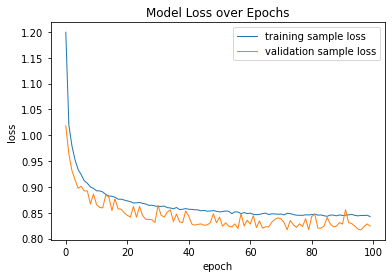

In [8]:
learningCurveLoss(history)

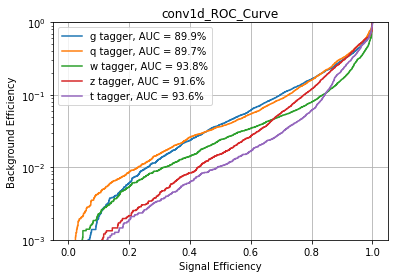

In [9]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')